In [1]:
import sys
import numpy as np
from scipy.stats import norm

# Include the parent directory in package searching path.
sys.path.append("../")

# from utils import plot_series
from matplotlib import pyplot as plt

np.random.seed(0)

## Markov Chain and Stationary Distribution

Suppose we use a Markov Chain to model the employment of new-grad in IT job market. We propose the following **transition matrix**, $A$:


|             | Unemployed  | Seeking | Working |
|-------------|-------------|---------|---------|
| Unemployed  | 0.2         | 0.8     | 0.0     |
| Seeking     | 0.1         | 0.6     | 0.3     |
| Working     | 0.1         | 0.1     | 0.8     |

Here, $A_{ij} = p(s_{t} = j | s_{t-1} = i)$, for example, the probability that an unemployed new-grad seeks a job is 0.8; the probability of a job seeker getting a job is 0.3. We assume there's no jump from Unemployed directly to Working, i.e. no nepotism :)

We also have some prior knowledge about the states at time 0, that is: the majority of students after graduation will seek a job, only a few of them have a job secured before graduation, and only a few will choose to live a different life - travelling the world - for instance.

Hence, we have a **prior distribution** of the states of the chain. $\pi_{0} = [0.1\;\; 0.7\;\; 0.2]$, note that this is a row vector.

**Objective**: study how the distribution of employment changes over time, i.e. what is $\pi_{t}$.

Let $\pi_t(j) = p(s_{t} = j)$, i.e. $\pi_{t}(\text{Working}) =$ at time $t$, the probability that people start Working.

$$
\begin{align}
\pi_t(j) &= \sum_{i} p(x_{t}=j|x_{t-1}=i)\pi_{t-1}(i) \\
       &= \sum_{i} A_{ij} \pi_{t-1}(i)\\
\end{align}
$$

Therefore, $\pi_{t} = \pi_{t-1} A$, more over, $\pi_{t} = \pi_{0} A^t$.

In [2]:
class StationaryDiscreteMarkovChain:
    
    def __init__(self, transition_matrix, prior, epoch=100):
        self.A = transition_matrix
        self.pi_0 = prior[:]
        self.pi_t = prior[:]
        self.curr_epoch = 0
        self.targer_epoch = epoch
    
    def step(self):
        self.pi_t = self.pi_t @ self.A
        self.curr_epoch += 1
        return self.pi_t
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_epoch < self.targer_epoch:
            return self.step()
        else:
            raise StopIteration

In [3]:
# we want to see the distribution after 30 time steps
epoch = 30

transition_matrix = np.array([[0.2, 0.8, 0.0], [0.1, 0.6, 0.3], [0.1, 0.1, 0.8]])
prior = np.array([0.1, 0.7, 0.2])
record = prior[:]

for pi in StationaryDiscreteMarkovChain(transition_matrix, prior, epoch=30):
    record = np.vstack((record, pi))

### Visualize the distribution after 30 time steps.

We can see that the distribution $\pi$ converges as time progresses, and this $\pi$ is called **stationary distribution**.

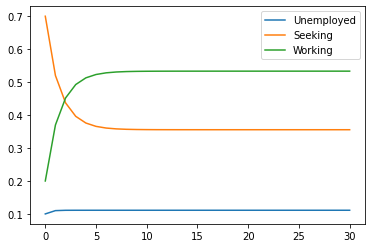

In [4]:
x = np.arange(31)
plt.plot(x, record[:,0], label="Unemployed")
plt.plot(x, record[:,1], label="Seeking")
plt.plot(x, record[:,2], label="Working")
plt.legend()
plt.show()

### Independent of starting distribution/prior

For different prior distribution, the Markov Chain always converges to a stationary distribution.

[0.11111111 0.35555556 0.53333333]
[0.11111111 0.35555556 0.53333333]
[0.11111111 0.35555556 0.53333333]
[0.11111111 0.35555556 0.53333333]
[0.11111111 0.35555556 0.53333333]


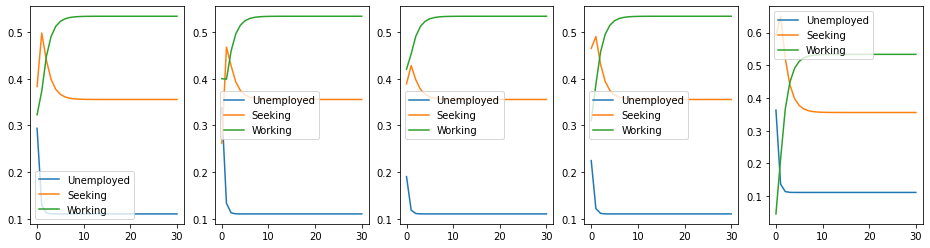

In [5]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    prior = np.random.rand(3)
    prior = prior / np.sum(prior)
    record = prior[:]
    for pi in StationaryDiscreteMarkovChain(transition_matrix, prior, epoch=30):
        record = np.vstack((record, pi))
    print(record[-1])
    ax[i].plot(x, record[:,0], label="Unemployed")
    ax[i].plot(x, record[:,1], label="Seeking")
    ax[i].plot(x, record[:,2], label="Working")
    ax[i].legend()
fig.set_figwidth(16)

### Detailed Balance

How can we construct a Markov Chain such that it eventually converges to a stationary distribution $\pi$? We construct a detailed balance Markov Chain.

**Detailed Balance**: $\pi_i A_{ij} = \pi_j A_{ji}, \forall i, j$

*Proof* Detailed Balance $\implies$ Stationary Distribution

Show: $\pi A = \pi$, which means proving $\forall i, \sum_{j} \pi_j A_{ji} = \pi_i$.

$$
\begin{align}
\sum_{j} \pi_j A_{ji} = \sum_{j} \pi_{i} A_{ij} = \pi_i \sum_{j} A_{ij} = \pi_{i} \cdot 1 = \pi_{i}\\
\end{align}
$$

Now, since we have shown Detailed Balance implies Stationary Distribution, we want to construct a detailed balanced Markov Chain that converges to $\pi = p(x)$.

## MCMC - Metropolis Hastings

We construct a Markov Chain:

Let $\pi = \tilde{p}(x)$, our objective function to sample from,

Let $\tilde{q}(x'|x_t)$ be a proposal distribution / proposal transition function $\tilde{q}:\mathbb{R}^2→[0,1]$.

Let $\alpha(x'|x_t)$ be an rejection/acceptance function, where $\alpha(x'|x_t) = min\{1, \frac{\tilde{p}(x') \tilde{q}(x_t | x')}{\tilde{p}(x_t) \tilde{q}(x'| x_t)}\}$, i.e. the probability that we accept new sample $x'$ given the current sample $x_t$.

The transition matrix is hence $Q = \tilde{q} ⊙ \alpha$

We want to prove detailed balance:

$$
\tilde{p}(x_t) \tilde{q}(x'| x_t) \alpha(x'|x_t) = \tilde{p}(x') \tilde{q}(x_t | x') \alpha(x_t|x')
$$

Notation explanation: we currently have generated $t$ samples, $x_1, ..., x_t$. The newly generated sample is $x'$.

*proof* We want to prove the statement in two cases:

**Case 1**: $1 < \frac{\tilde{p}(x') \tilde{q}(x_t | x')}{\tilde{p}(x_t) \tilde{q}(x'| x_t)}$

LHS: 

$$
\begin{align}
\alpha(x'|x_t) &= min\{1, \frac{\tilde{p}(x') \tilde{q}(x_t | x')}{\tilde{p}(x_t) \tilde{q}(x'| x_t)}\} = 1\\
\tilde{p}(x_t) \tilde{q}(x'| x_t) \alpha(x'|x_t) &= \tilde{p}(x_t) \tilde{q}(x'| x_t)\\
\end{align}
$$

RHS:

$$
\begin{align}
\alpha(x_t|x') &= min\{1, \frac{\tilde{p}(x_t) \tilde{q}(x' | x_t)}{\tilde{p}(x') \tilde{q}(x_t| x')}\} = \frac{\tilde{p}(x_t) \tilde{q}(x' | x_t)}{\tilde{p}(x') \tilde{q}(x_t| x')}\\
\tilde{p}(x') \tilde{q}(x_t | x') \alpha(x_t|x') &= \tilde{p}(x') \tilde{q}(x_t | x') \frac{\tilde{p}(x_t) \tilde{q}(x' | x_t)}{\tilde{p}(x') \tilde{q}(x_t| x')}\\
&=\tilde{p}(x_t) \tilde{q}(x' | x_t)\\
\end{align}
$$

Therefore, LHS = RHS.

**Case 2**: $\frac{\tilde{p}(x') \tilde{q}(x_t | x')}{\tilde{p}(x_t) \tilde{q}(x'| x_t)} < 1$

WLOG, we can use the same heuristics to prove.


Thus, we have constructed a Markov Chain that converges to a stationary distribution $\tilde{p}(x)$, and all accepted sample follows this distribution.

In [6]:
class MetropolisHastingsSampler:
    """In this implementation of Metropolis Hastings, we use Normal(1, 2) as the proposal transition distribution.
    """

    def __init__(self, obj_func, dim=1, num_samples=10000, burn_in=20):
        self.p = np.vectorize(obj_func)
        self.d = dim
        self.N = num_samples
        self.burn_in = burn_in
        self.mean = 1
        self.var = 2
  
    def sample(self):
        samples = np.zeros((self.N + self.burn_in, self.d))
        cnt = 1

        # randomly initialize x_0.
        x = np.random.rand(self.d)

        while cnt < self.N + self.burn_in:
            # Sample a new data point by generating a random walk 
            # centered at the current datapoint.
            x_new = norm.rvs(loc=x, scale=self.var, size=1, random_state=None)
    
            # q(x_t | x') = the probability of x_t appearing in the neighbor of a Normal centered at x'.
            likelihood_x_t = norm(x_new, self.var).pdf(x)
            # q(x' | x_t) = the probability of x' appearing in the neighbor of a Normal centered at x_t.
            lilelihood_x_prime = norm(x, self.var).pdf(x_new)
            
            # Compute acceptance rate.
            enum = (self.p(x_new) * likelihood_x_t)
            demon = (self.p(x) * lilelihood_x_prime)
            if demon == 0.:
                continue
    
            alpha = min(1., enum / demon)
            u = np.random.rand()

            if u < alpha:
                samples[cnt] = x_new
                x = x_new
            else:
                # reuse sample
                samples[cnt] = x

            cnt += 1

        return samples[self.burn_in:]

### Test sampling

- Tent function

In [7]:
def tent_pdf(x):
    if 0 <= x < 1:
        return x
    elif 1 <= x <= 2:
        return 2 - x
    else:
        return 0

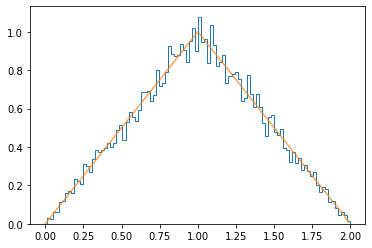

In [8]:
samples = MetropolisHastingsSampler(np.vectorize(tent_pdf), dim=1, num_samples=100000, burn_in=20).sample()

counts, bins = np.histogram(samples, density=True, bins=100)
plt.stairs(counts, bins, label='Sample Distribution')

x = np.arange(0, 2, 0.01)
plt.plot(x, np.vectorize(tent_pdf)(x), label="p(x)", alpha=0.7)